# Tarea Dask

## Instrucciones generales
- Esta tarea debe realizarse de manera individual
- Este notebook (resuelto) debe ser subido al github del proyecto en la carpeta de tareas (creen una carpeta dentro de esa carpeta y agreguen su notebook reuelto)
- Fecha límite: Lunes 25 de noviembre de 2024 a las 11:59 p.m
- Deben realizar las cuatro secciones
- Puedes agregar tantas celdas de código y explicaciones como veas necesario, solo manten la estructura general

## Sección 0 Creación y Configuración del cliente de Dask
Ejercicio 0: Configuración del cliente
1. Crea un cliente local de Dask que inicie un clúster en tu máquina.
2. Configura el cliente para que tenga las siguientes características (elige un par de las opciones de trabajadores e hilos):
    - Número de trabajadores: 2 / 4
    - Memoria máxima por trabajador: 1GB
    - Threads por trabajador: 4 / 2
3. Verifica que el cliente esté funcionando correctamente mostrando:
    - Resumen de los trabajadores activos.
    - Dashboard disponible (URL del panel de control de Dask).
    * Tip: Checa los parámetros del cliente que creeaste.

*Nota*: Puedes hacer que corra en el puerto que desees.

In [1]:
from dask.distributed import Client, LocalCluster

# Configuración del clúster local
cluster = LocalCluster(
    n_workers=2,          # Número de trabajadores
    threads_per_worker=4, # Hilos por trabajador
    memory_limit="1GB",   # Memoria máxima por trabajador
    dashboard_address=":8787"  # Especifica el puerto del Dashboard
)

# Creación del cliente
client = Client(cluster)

# Verificar la configuración del cliente
print("Resumen del cliente:")
print(client)

# Mostrar la URL del Dashboard
print("\nURL del Dashboard de Dask:")
print(client.dashboard_link)

# Obtener y mostrar información de los trabajadores activos
workers = client.scheduler_info()['workers']
print("\nTrabajadores activos:")
for worker, info in workers.items():
    print(f" - {worker}: {info['nthreads']} hilos, {info['memory_limit'] / 1e9:.2f} GB memoria")


Resumen del cliente:
<Client: 'tcp://127.0.0.1:36839' processes=2 threads=8, memory=1.86 GiB>

URL del Dashboard de Dask:
http://127.0.0.1:8787/status

Trabajadores activos:
 - tcp://127.0.0.1:32879: 4 hilos, 1.00 GB memoria
 - tcp://127.0.0.1:40697: 4 hilos, 1.00 GB memoria


## Sección 1 Delayed
Ejercicio 1: Procesamiento de datos 

1. Genera datos simulados (por ejemplo, ventas diarias) para 10 sucursales durante 365 días.
    - Cada sucursal debe tener datos generados aleatoriamente para "Ingresos" y "Costos".
    - Utiliza una función para generar los datos simulados.
2. Usa Dask Delayed para calcular:
    - Las ganancias diarias por sucursal.
    - La sucursal con mayor ganancia promedio.
3. Genera un grafo de tareas que visualice estas operaciones y explica por qué elegiste paralelizar de esa forma, genera una visualización del grafo.

Sucursal con mayor ganancia promedio: Sucursal_1


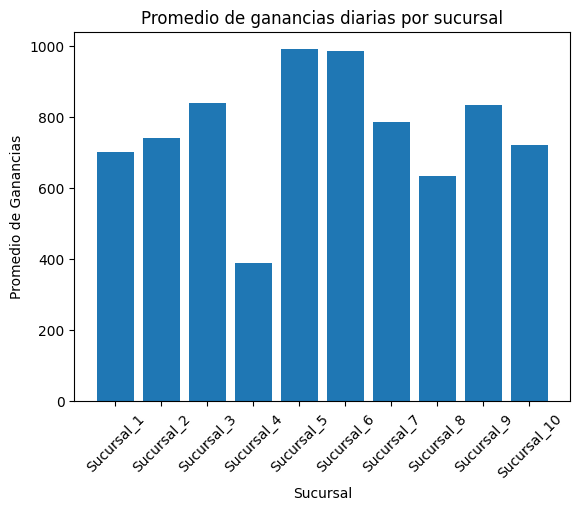

In [ ]:
import dask
from dask import delayed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Generar datos simulados
def generar_datos_sucursal(n_dias=365):
    """Genera un DataFrame simulado con ingresos y costos para una sucursal."""
    rng = np.random.default_rng()
    datos = {
        "Ingresos": rng.uniform(1000, 10000, n_dias),  # Ingresos diarios
        "Costos": rng.uniform(500, 9000, n_dias),     # Costos diarios
    }
    return pd.DataFrame(datos)

# Generar datos simulados para 10 sucursales
sucursales = {f"Sucursal_{i+1}": delayed(generar_datos_sucursal)() for i in range(10)}

# 2. Calcular ganancias diarias por sucursal
def calcular_ganancias(df):
    """Calcula las ganancias diarias (Ingresos - Costos)."""
    df["Ganancias"] = df["Ingresos"] - df["Costos"]
    return df

# Aplicar la función para calcular las ganancias
sucursales_con_ganancias = {nombre: delayed(calcular_ganancias)(df) for nombre, df in sucursales.items()}

# Calcular el promedio de ganancias por sucursal
def calcular_promedio_ganancias(df):
    """Calcula el promedio de ganancias diarias."""
    return df["Ganancias"].mean()

promedios_ganancias = {nombre: delayed(calcular_promedio_ganancias)(df) for nombre, df in sucursales_con_ganancias.items()}

# Determinar la sucursal con mayor ganancia promedio
def determinar_maximo(promedios):
    """Devuelve la sucursal con mayor ganancia promedio."""
    return max(promedios, key=promedios.get)

sucursal_max_ganancia = delayed(determinar_maximo)(promedios_ganancias)

# 3. Generar el grafo de tareas
dask.visualize(sucursal_max_ganancia, filename="grafo_tareas", format="png")

# Ejecutar la tarea
resultado = sucursal_max_ganancia.compute()

# Mostrar resultados
print("Sucursal con mayor ganancia promedio:", resultado)

# Visualización de los promedios de ganancias
promedios = dask.compute(promedios_ganancias)[0]
plt.bar(promedios.keys(), promedios.values())
plt.xticks(rotation=45)
plt.title("Promedio de ganancias diarias por sucursal")
plt.xlabel("Sucursal")
plt.ylabel("Promedio de Ganancias")
plt.show()


Elección de la Paralelización
La paralelización fue diseñada de la siguiente forma:

Generación de Datos Simulados:

Cada sucursal genera datos aleatoriamente de manera independiente. Esto se paraleliza porque no hay dependencia entre las sucursales en este paso.

Cálculo de Ganancias:

El cálculo de las ganancias diarias (Ingresos - Costos) se realiza de forma separada para cada sucursal, lo que permite que todas las sucursales sean procesadas en paralelo.

Cálculo del Promedio:

Una vez calculadas las ganancias, el promedio de ganancias para cada sucursal se calcula independientemente.
Determinación de la Sucursal con Mayor Ganancia Promedio:

Este paso depende de los resultados de los promedios de ganancias calculados anteriormente, pero no puede comenzar hasta que todas las sucursales hayan terminado.
Ventajas de Paralelizar de esta Forma

Independencia de las Tareas:
Cada operación en las sucursales es independiente, lo que permite aprovechar múltiples hilos o trabajadores para realizar los cálculos en paralelo.

Escalabilidad:

Si el número de sucursales o los datos aumentan, esta estructura permite agregar más recursos para manejar el incremento de la carga.

Eficiencia:

Solo las operaciones necesarias son ejecutadas, y Dask maneja automáticamente la sincronización de las dependencias.

## Sección 2 Dask Dataframes
Ejercicio 2: Limpieza y análisis de datos reales

1. Descarga un conjunto de datos masivo (puedes usar la colección de *nycflights* que se encuentra en `data/nycflights/`).
2. Carga los datos en un Dask DataFrame. 
    - Elige adecuadamente el número de particiones (que quepan en memoria de los `workers`)
3. Realiza las siguientes tareas:
    - Limpia los valores faltantes en las columnas `ArrDelay` y `DepDelay`, rellenándolos con la mediana de cada columna.
    - Calcula el retraso promedio (`DepDelay`) por mes y aerolínea.
    - Encuentra el aeropuerto de origen con más vuelos retrasados.

*Nota*: **Evita** convertir el DataFrame a pandas e **intenta** realizar `.compute()` solo cuando sea necesario.

Estructura inicial del DataFrame:
     Year  Month  DayofMonth UniqueCarrier  DepDelay  ArrDelay Origin
0  1990.0    1.0         1.0            US      41.0      46.0    EWR
1  1990.0    1.0         2.0            US       7.0      -1.0    EWR
2  1990.0    1.0         3.0            US       6.0       9.0    EWR
3  1990.0    1.0         4.0            US       2.0       9.0    EWR
4  1990.0    1.0         5.0            US       9.0       5.0    EWR


2024-11-24 20:36:04,556 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 807.36 MiB -- Worker memory limit: 0.93 GiB
2024-11-24 20:36:04,696 - distributed.worker.memory - WARNING - Worker is at 74% memory usage. Resuming worker. Process memory: 710.20 MiB -- Worker memory limit: 0.93 GiB
2024-11-24 20:36:09,194 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 783.07 MiB -- Worker memory limit: 0.93 GiB
2024-11-24 20:36:09,314 - distributed.worker.memory - WARNING - Worker is at 77% memory usage. Resuming worker. Process memory: 738.73 MiB -- Worker memory limit: 0.93 GiB
2024-11-24 20:36:09,703 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 773.68 MiB -- Worker memory limit: 0.93 GiB
2024-11-24 20:36:09,810 - distributed.worker.memory - WARNING - Worker is at 68% memory usage. Resuming worker. Process memory: 657.25 MiB -


Valores faltantes después de la limpieza:


2024-11-24 20:36:15,533 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 809.95 MiB -- Worker memory limit: 0.93 GiB
2024-11-24 20:36:15,594 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 689.38 MiB -- Worker memory limit: 0.93 GiB
2024-11-24 20:36:15,924 - distributed.worker.memory - WARNING - Worker is at 67% memory usage. Resuming worker. Process memory: 646.32 MiB -- Worker memory limit: 0.93 GiB
2024-11-24 20:36:16,164 - distributed.worker.memory - WARNING - Worker is at 85% memory usage. Pausing worker.  Process memory: 819.45 MiB -- Worker memory limit: 0.93 GiB
2024-11-24 20:36:16,548 - distributed.worker.memory - WARNING - Worker is at 65% memory usage. Resuming worker. Process memory: 6

Year             0
Month            0
DayofMonth       0
UniqueCarrier    0
DepDelay         0
ArrDelay         0
Origin           0
dtype: int64


2024-11-24 20:36:21,439 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 751.03 MiB -- Worker memory limit: 0.93 GiB
2024-11-24 20:36:21,514 - distributed.worker.memory - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 792.61 MiB -- Worker memory limit: 0.93 GiB
2024-11-24 20:36:22,002 - distributed.worker.memory - WARNING - Worker is at 67% memory usage. Resuming worker. Process memory: 646.80 MiB -- Worker memory limit: 0.93 GiB



Retraso promedio (DepDelay) por mes y aerolínea:
Month  UniqueCarrier
1.0    AA                8.963504
       CO               11.693346
       DL                9.249338
       EA               24.258191
       HP               18.697144
                          ...    
6.0    ML (1)            3.364372
7.0    ML (1)            4.964143
8.0    ML (1)            9.478431
9.0    ML (1)            2.583673
10.0   ML (1)            4.493976
Name: DepDelay, Length: 130, dtype: float64


2024-11-24 20:36:27,100 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 770.38 MiB -- Worker memory limit: 0.93 GiB
2024-11-24 20:36:27,206 - distributed.worker.memory - WARNING - Worker is at 75% memory usage. Resuming worker. Process memory: 717.15 MiB -- Worker memory limit: 0.93 GiB
2024-11-24 20:36:27,404 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 774.32 MiB -- Worker memory limit: 0.93 GiB
2024-11-24 20:36:27,552 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 761.83 MiB -- Worker memory limit: 0.93 GiB



Aeropuerto de origen con más vuelos retrasados:
EWR 194900


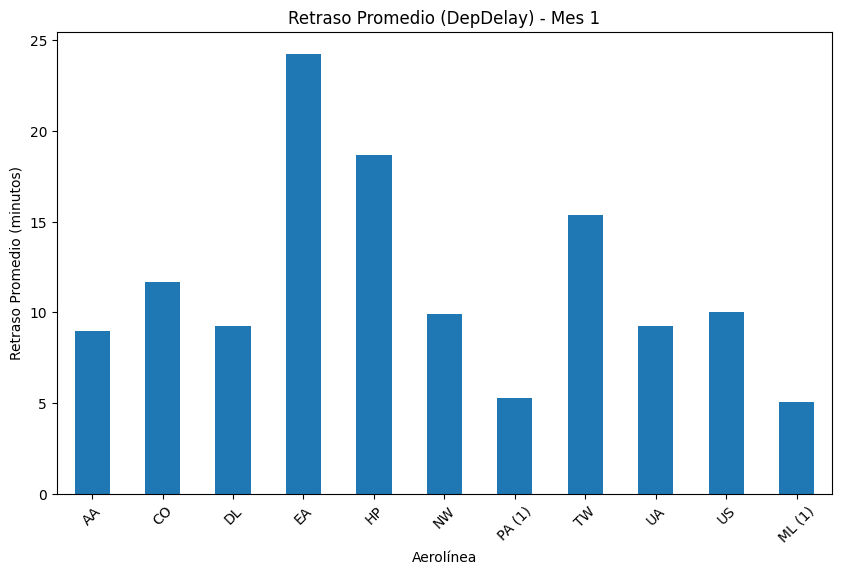

In [12]:
import dask.dataframe as dd
import matplotlib.pyplot as plt

# 1. Cargar el conjunto de datos masivo (nycflights)
data_path = "data/nycflights/*.csv"

# Cargar datos en un Dask DataFrame con tipos y particiones ajustados
df = dd.read_csv(
    data_path,
    assume_missing=True,
    blocksize="128MB",  # Ajustar el tamaño de partición
    dtype={
        "TailNum": "object",
        "UniqueCarrier": "object",
        "Origin": "object",
        "Dest": "object",
        "DepDelay": "float64",
        "ArrDelay": "float64",
    }
)

# Seleccionar columnas relevantes para reducir el uso de memoria
columnas_relevantes = ['Year', 'Month', 'DayofMonth', 'UniqueCarrier', 
                       'DepDelay', 'ArrDelay', 'Origin']
df = df[columnas_relevantes]

print("Estructura inicial del DataFrame:")
print(df.head())

# 2. Limpieza de datos
# Calcular la mediana como el percentil 50
arr_delay_median = df['ArrDelay'].quantile(0.5).compute()
dep_delay_median = df['DepDelay'].quantile(0.5).compute()

# Rellenar valores faltantes con la mediana
df['ArrDelay'] = df['ArrDelay'].fillna(arr_delay_median)
df['DepDelay'] = df['DepDelay'].fillna(dep_delay_median)

# Verificar valores faltantes después de la limpieza
print("\nValores faltantes después de la limpieza:")
print(df.isnull().sum().compute())

# 3a. Calcular el retraso promedio por mes y aerolínea
retraso_promedio = df.groupby(['Month', 'UniqueCarrier'])['DepDelay'].mean().compute()
print("\nRetraso promedio (DepDelay) por mes y aerolínea:")
print(retraso_promedio)

# 3b. Encontrar el aeropuerto de origen con más vuelos retrasados
# Filtrar vuelos retrasados
vuelos_retrasados = df[df['DepDelay'] > 15]

# Contar vuelos retrasados por aeropuerto de origen
aeropuerto_mas_retrasado = vuelos_retrasados['Origin'].value_counts().compute()
print("\nAeropuerto de origen con más vuelos retrasados:")
print(aeropuerto_mas_retrasado.idxmax(), aeropuerto_mas_retrasado.max())

# Visualización adicional: Graficar retraso promedio por aerolínea en un mes específico
mes = 1  # Cambiar según el mes deseado
if mes in retraso_promedio.index.get_level_values('Month'):
    retrasos_mes = retraso_promedio.loc[mes]
    retrasos_mes.plot(kind='bar', figsize=(10, 6))
    plt.title(f"Retraso Promedio (DepDelay) - Mes {mes}")
    plt.xlabel("Aerolínea")
    plt.ylabel("Retraso Promedio (minutos)")
    plt.xticks(rotation=45)
    plt.show()
else:
    print(f"No hay datos disponibles para el mes {mes}.")



## Sección 3 Dask Arrays

Ejercicio 3: Procesamiento numérico avanzado

1. Crea un arreglo de 10,000 x 10,000 con valores aleatorios usando Dask Array, utiliza un tamaño de chunks adecuado, ¿es mejor que sean cuadrados?.
2. Realiza las siguientes operaciones:
    - Calcula la suma de cada fila.
    - Encuentra la fila con el valor máximo promedio.
    - Multiplica todo el arreglo por un factor escalar (por ejemplo, 2.5).
3. Divide el arreglo nuevamente en 100 bloques y compara la rapidez.

In [13]:
import dask.array as da
import numpy as np
import time

# 1. Crear un arreglo de 10,000 x 10,000 con valores aleatorios
# Elegir un tamaño de chunk cuadrado inicial
chunk_size = (1000, 1000)  # Bloques cuadrados de 1,000 x 1,000
arr = da.random.random(size=(10000, 10000), chunks=chunk_size)

print("Arreglo creado con chunks:", arr.chunks)

# 2a. Calcular la suma de cada fila
start = time.time()
suma_filas = arr.sum(axis=1).compute()
end = time.time()
print(f"\nSuma de cada fila calculada en {end - start:.2f} segundos.")

# 2b. Encontrar la fila con el valor máximo promedio
start = time.time()
promedio_filas = arr.mean(axis=1).compute()  # Promedio de cada fila
fila_max_promedio = np.argmax(promedio_filas)  # Índice de la fila con mayor promedio
end = time.time()
print(f"\nFila con el máximo promedio: {fila_max_promedio} (calculado en {end - start:.2f} segundos).")

# 2c. Multiplicar todo el arreglo por un factor escalar
start = time.time()
arr_escalado = (arr * 2.5).compute()  # Multiplicar por 2.5
end = time.time()
print(f"\nArreglo escalado calculado en {end - start:.2f} segundos.")

# 3. Re-dividir el arreglo en 100 bloques (tamaño aproximado de 1000 x 1000) y comparar
start = time.time()
arr_rechunked = arr.rechunk((1000, 1000))
suma_rechunked = arr_rechunked.sum().compute()
end = time.time()
print(f"\nOperación con chunks de 100 bloques calculada en {end - start:.2f} segundos.")

# Comparar con bloques más pequeños (e.g., 500 x 500)
start = time.time()
arr_rechunked_small = arr.rechunk((500, 500))
suma_rechunked_small = arr_rechunked_small.sum().compute()
end = time.time()
print(f"\nOperación con chunks más pequeños (500x500) calculada en {end - start:.2f} segundos.")


Arreglo creado con chunks: ((1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000), (1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000))

Suma de cada fila calculada en 3.14 segundos.

Fila con el máximo promedio: 2654 (calculado en 0.79 segundos).


2024-11-24 20:42:20,086 - distributed.worker.memory - WARNING - gc.collect() took 1.049s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2024-11-24 20:42:24,137 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 685.48 MiB -- Worker memory limit: 0.93 GiB



Arreglo escalado calculado en 13.01 segundos.

Operación con chunks de 100 bloques calculada en 0.81 segundos.

Operación con chunks más pequeños (500x500) calculada en 3.00 segundos.


## Sección 4 Futures
Ejercicio 4: Distribución de tareas dinámicas

1. Implementa una función que calcule la raíz cuadrada de una lista de 100,000 números enteros generados aleatoriamente.
2. Divide la lista en 10 partes iguales y usa Dask Futures para calcular la raíz cuadrada de cada parte en paralelo.
3. Recolecta los resultados y calcula:
    - El promedio de todos los números procesados.
    - El tiempo total de ejecución (incluyendo envío y recolección de tareas).
4. Observa como se distribuye la carga en el cliente.

*Nota*: en los ejercicios ya vimos como determinar si ya se cumplío una tarea.

In [16]:
from dask.distributed import Client, LocalCluster
import numpy as np
import time

# 1. Configurar el cliente de Dask
cluster = LocalCluster()  # Crea un clúster local
client = Client(cluster)  # Conecta el cliente
print("Dashboard URL:", client.dashboard_link)

# 2. Generar una lista de números aleatorios
num_elements = 100_000
lista_numeros = np.random.randint(1, 100, size=num_elements)  # Evitar sqrt(0)

# Dividir la lista en 10 partes iguales
chunks = np.array_split(lista_numeros, 10)

# 3. Definir la función para calcular la raíz cuadrada
def calcular_raiz_cuadrada(numeros):
    """Calcula la raíz cuadrada de una lista de números."""
    return np.sqrt(numeros)

# Enviar tareas al clúster usando Futures
start_time = time.time()

futures = [client.submit(calcular_raiz_cuadrada, chunk) for chunk in chunks]
print("\nTareas enviadas al clúster.")

# Recolectar resultados
resultados = client.gather(futures)  # Traer resultados al cliente
end_time = time.time()

# Combinar todos los resultados
todos_los_resultados = np.concatenate(resultados)

# 4. Calcular el promedio y tiempo de ejecución
promedio_resultados = todos_los_resultados.mean()
tiempo_total = end_time - start_time

# Imprimir resultados
print(f"\nPromedio de los números procesados: {promedio_resultados:.2f}")
print(f"Tiempo total de ejecución: {tiempo_total:.2f} segundos")

# 5. Monitoreo del cliente
print("\nResumen del cliente:")
print(client)

# 6. Distribución de la carga
worker_info = client.scheduler_info()['workers']
for worker, info in worker_info.items():
    print(f"\nTrabajador: {worker}")
    print(f" - Hilos: {info['nthreads']}")
    print(f" - Métricas del trabajador:")
    for key, value in info['metrics'].items():
        print(f"   {key}: {value}")



/home/roddav/itam/fuentes_de_datos/fdd_o24_personal_proyectos_finales/proyecto_dask/notebooks/venv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37089 instead
  warnings.warn(


Dashboard URL: http://127.0.0.1:37089/status

Tareas enviadas al clúster.

Promedio de los números procesados: 6.69
Tiempo total de ejecución: 0.31 segundos

Resumen del cliente:
<Client: 'tcp://127.0.0.1:39325' processes=4 threads=12, memory=3.75 GiB>

Trabajador: tcp://127.0.0.1:33265
 - Hilos: 3
 - Métricas del trabajador:
   task_counts: {}
   bandwidth: {'total': 100000000, 'workers': {}, 'types': {}}
   digests_total_since_heartbeat: {}
   managed_bytes: 0
   spilled_bytes: {'memory': 0, 'disk': 0}
   transfer: {'incoming_bytes': 0, 'incoming_count': 0, 'incoming_count_total': 0, 'outgoing_bytes': 0, 'outgoing_count': 0, 'outgoing_count_total': 0}
   event_loop_interval: 0.02
   cpu: 0.0
   memory: 58548224
   time: 1732502912.0972095
   host_net_io: {'read_bps': 0.0, 'write_bps': 0.0}
   host_disk_io: {'read_bps': 0.0, 'write_bps': 0.0}
   num_fds: 17

Trabajador: tcp://127.0.0.1:34247
 - Hilos: 3
 - Métricas del trabajador:
   task_counts: {}
   bandwidth: {'total': 100000000, 